In [1]:
pip install tensorflow opencv-python numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


C:\Users\Admin\AppData\Local\Temp\ipykernel_1576\1536184765.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


Epoch 1/10


C:\Users\Admin\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8342 - loss: 0.3705

C:\Users\Admin\anaconda3\envs\ML\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 104s 518ms/step - accuracy: 0.8346 - loss: 0.3696 - val_accuracy: 0.9212 - val_loss: 0.1610 - learning_rate: 1.0000e-04
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 100s 523ms/step - accuracy: 0.9793 - loss: 0.0730 - val_accuracy: 0.9252 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 114s 596ms/step - accuracy: 0.9750 - loss: 0.0552 - val_accuracy: 0.9497 - val_loss: 0.1160 - learning_rate: 1.0000e-04
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 116s 610ms/step - accuracy: 0.9815 - loss: 0.0492 - val_accuracy: 0.9345 - val_loss: 0.1420 - learning_rate: 1.0000e-04
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 112s 586ms/step - accuracy: 0.9838 - loss: 0.0401 - val_accuracy: 0.9497 - val_loss: 0.1112 - learning_rate: 1.0000e-04
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 114s 594ms/step - accuracy: 0.9857 - loss: 0.0376 - val_accuracy: 0.9279 - val_loss: 0.1599 - learning_rate: 1.0000e-04
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 116s 602ms/

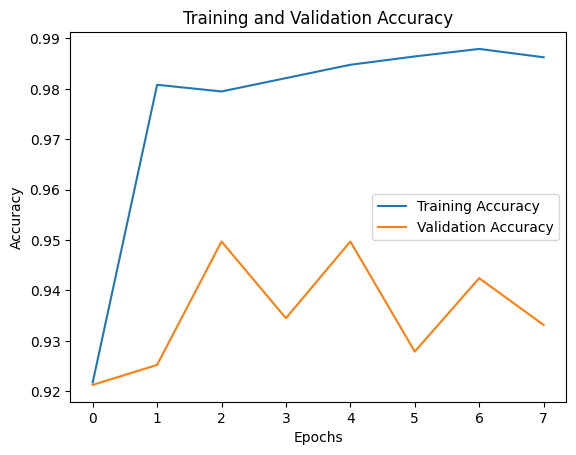

48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step


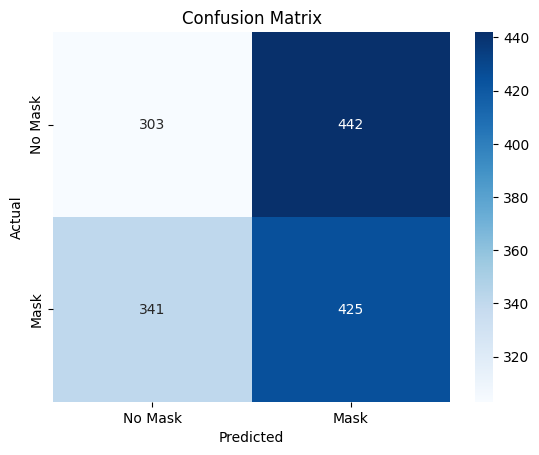

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.47      0.41      0.44       745
        Mask       0.49      0.55      0.52       766

    accuracy                           0.48      1511
   macro avg       0.48      0.48      0.48      1511
weighted avg       0.48      0.48      0.48      1511



In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Load Data
train_dir = "C:/Users/Admin/auro/data/train" 
test_dir = "C:/Users/Admin/auro/data/test"
IMG_SIZE = 150
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255, rotation_range=20, zoom_range=0.2, shear_range=0.2,
    horizontal_flip=True, fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="binary"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="binary"
)

# Load Pretrained Model (MobileNetV2)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

# Create Custom Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification (Mask/No Mask)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Train Model
history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[early_stopping, lr_scheduler])

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Keep first 100 layers frozen
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

# Fine-tune the model
history_fine_tune = model.fit(train_generator, validation_data=test_generator, epochs=5, callbacks=[early_stopping, lr_scheduler])

# Save model in recommended format
model.save("face_mask_detector.keras")
print("Model training complete and saved!")

# Plot Accuracy Graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate Model
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['No Mask', 'Mask']))

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("face_mask_detector.keras")

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Avoid mirroring
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(50, 50))

    for (x, y, w, h) in faces:
        margin = 15
        x, y, w, h = max(0, x-margin), max(0, y-margin), min(w+2*margin, frame.shape[1]-x), min(h+2*margin, frame.shape[0]-y)
        face = frame[y:y+h, x:x+w]

        # Preprocess face image
        try:
            face = cv2.resize(face, (150, 150))
        except:
            continue  # Skip if resizing fails

        face = face.astype("float32") / 255.0
        face = np.expand_dims(face, axis=0)

        # Predict
        prediction = model.predict(face)[0][0]
        confidence = round((1 - prediction) * 100 if prediction < 0.5 else prediction * 100, 2)

        # Label and Color
        if prediction < 0.4:
            label = f"Mask ({confidence}%)"
            color = (0, 255, 0)
        else:
            label = f"No Mask ({confidence}%)"
            color = (0, 0, 255)

        # Draw Rectangle and Label
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Face Mask Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━